### Парсим данные через yfinance

In [1]:
# from utils.parser import parse_single_ticker

# parse_single_ticker(
#     ticker="MSFT",
#     path_to_save='data/',
#     timeframe='1d',
#     start_date='2020-01-01',
#     target_len=32,
#     history_len=256,
#     split_coef=0.1,
# )

In [2]:
# from utils.parser import parse_snp500

# parse_snp500(
#     path_to_save='data/',
#     timeframe='1d',
#     start_date='2020-01-01',
#     target_len=32,
#     history_len=256,
#     split_coef=0.1,
# )

### Получаем датасет

In [3]:
# # utils/dataset.py
# import os
# import pandas as pd
# import numpy as np
# import torch
# from torch.utils.data import Dataset
# import glob
# from typing import Optional, Callable, Tuple, Any

# # Предполагаем, что TradingNormalizer будет в отдельном файле
# # from utils.normalizer import TradingNormalizer

# # Для демонстрации создадим заглушку, позже её можно будет заменить на реальную реализацию
# class TradingNormalizer:
#     def __init__(self, method='log_returns'):
#         self.method = method
        
#     def __call__(self, chunk):
#         # Заглушка - просто возвращает исходный чанк
#         # Реализация будет позже
#         return chunk


# class TradingDataset(Dataset):
#     """
#     Датасет для торговли, который загружает сырые чанки и нормализует их на лету.
#     """
#     def __init__(
#         self, 
#         data_path: str, 
#         mode: str = 'train',
#         history_len: int = 256,
#         target_len: int = 32,
#         normalizer: Optional[TradingNormalizer] = None,
#     ):
#         """
#         Args:
#             data_path (str): Путь к директории с данными.
#             mode (str): Режим работы ('train' или 'validation').
#             history_len (int): Длина исторических данных.
#             target_len (int): Длина целевых данных.
#             normalizer (TradingNormalizer, optional): Нормализатор данных.
#         """
#         self.data_path = data_path
#         self.mode = mode
#         self.history_len = history_len
#         self.target_len = target_len
#         self.normalizer = normalizer
        
#         # Проверяем существование директории
#         mode_path = os.path.join(data_path, mode)
#         if not os.path.exists(mode_path):
#             raise FileNotFoundError(f"Mode directory not found: {mode_path}")
        
#         # Получаем все пути к тикерам
#         self.ticker_paths = glob.glob(os.path.join(mode_path, '*'))
        
#         if not self.ticker_paths:
#             raise ValueError(f"No ticker directories found in {mode_path}")
        
#         # Собираем все чанки
#         self.samples = []
#         self._collect_samples()
        
#         if len(self.samples) == 0:
#             raise ValueError(f"No valid chunks found in {mode_path}")
        
#         print(f"Found {len(self.samples)} samples for {mode} mode")
    
#     def _collect_samples(self):
#         """Собирает все доступные чанки."""
#         for ticker_path in self.ticker_paths:
#             if not os.path.isdir(ticker_path):
#                 continue
                
#             # Получаем все chunk файлы для данного тикера
#             chunk_files = glob.glob(os.path.join(ticker_path, 'chunk_*.csv'))
            
#             for chunk_file in chunk_files:
#                 # Проверяем, что chunk файл не пустой
#                 if not os.path.exists(chunk_file) or os.path.getsize(chunk_file) == 0:
#                     continue
                    
#                 self.samples.append({
#                     'chunk_file': chunk_file,
#                     'ticker': os.path.basename(ticker_path)
#                 })
    
#     def __len__(self):
#         """Возвращает общее количество samples."""
#         return len(self.samples)
    
#     def __getitem__(self, idx):
#         """
#         Возвращает один sample по индексу.
        
#         Returns:
#             dict: {
#                 'history': torch.Tensor of shape [history_len, 5],
#                 'target': torch.Tensor of shape [target_len, 1], # Only Close prices
#                 'ticker': str
#             }
#         """
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
#         sample_info = self.samples[idx]
        
#         try:
#             # Загружаем чанк данных
#             # Ожидаем CSV с 5 столбцами: Open, High, Low, Close, Volume
#             chunk_df = pd.read_csv(sample_info['chunk_file'], header=None)
#             if chunk_df.empty or chunk_df.shape[1] != 5:
#                 raise ValueError(f"Chunk file format error: {sample_info['chunk_file']}. "
#                                  f"Expected 5 columns, got {chunk_df.shape[1] if not chunk_df.empty else 0}")
            
#             # Преобразуем в numpy массив
#             chunk_data = chunk_df.values.astype(np.float32) # [history_len + target_len, 5]
            
#             # Проверяем размер
#             expected_len = self.history_len + self.target_len
#             if chunk_data.shape[0] != expected_len:
#                 raise ValueError(f"Chunk length error: expected {expected_len}, got {chunk_data.shape[0]}")
            
#             # Применяем нормализацию если задана
#             if self.normalizer:
#                 normalized_chunk = self.normalizer(chunk_data)
#             else:
#                 normalized_chunk = chunk_data
            
#             # Разделяем на историю и таргет
#             history_data = normalized_chunk[:self.history_len]     # [history_len, 5]
#             target_data = normalized_chunk[self.history_len:]      # [target_len, 5]
            
#             # Извлекаем только цены закрытия (индекс 3) для таргета
#             target_close_prices = target_data[:, 3:4]             # [target_len, 1]
            
#             # Формируем sample
#             sample = {
#                 'history': torch.from_numpy(history_data),        # [history_len, 5]
#                 'target': torch.from_numpy(target_close_prices),  # [target_len, 1]
#                 'ticker': sample_info['ticker']
#             }
            
#             return sample
            
#         except Exception as e:
#             print(f"Error loading sample {idx}: {e}")
#             print(f"Chunk file: {sample_info['chunk_file']}")
#             # Возвращаем None или raise исключение
#             raise e


In [39]:
from utils.dataset import TradingDataset, TradingNormalizer

normalizer = TradingNormalizer()

dataset = TradingDataset(
    data_path='data/',
    mode='train',
    history_len=256,
    target_len=32,
    normalizer=normalizer,
)

Found 507130 samples for train mode


History shape: torch.Size([256, 5])
Target shape: torch.Size([32, 1])
Ticker: CRL
Stats: {'first_price_0': np.float32(194.19), 'first_price_1': np.float32(197.17), 'first_price_2': np.float32(191.8), 'first_price_3': np.float32(195.22), 'volume_mean': np.float32(620391.0), 'volume_std': np.float32(368623.03)}


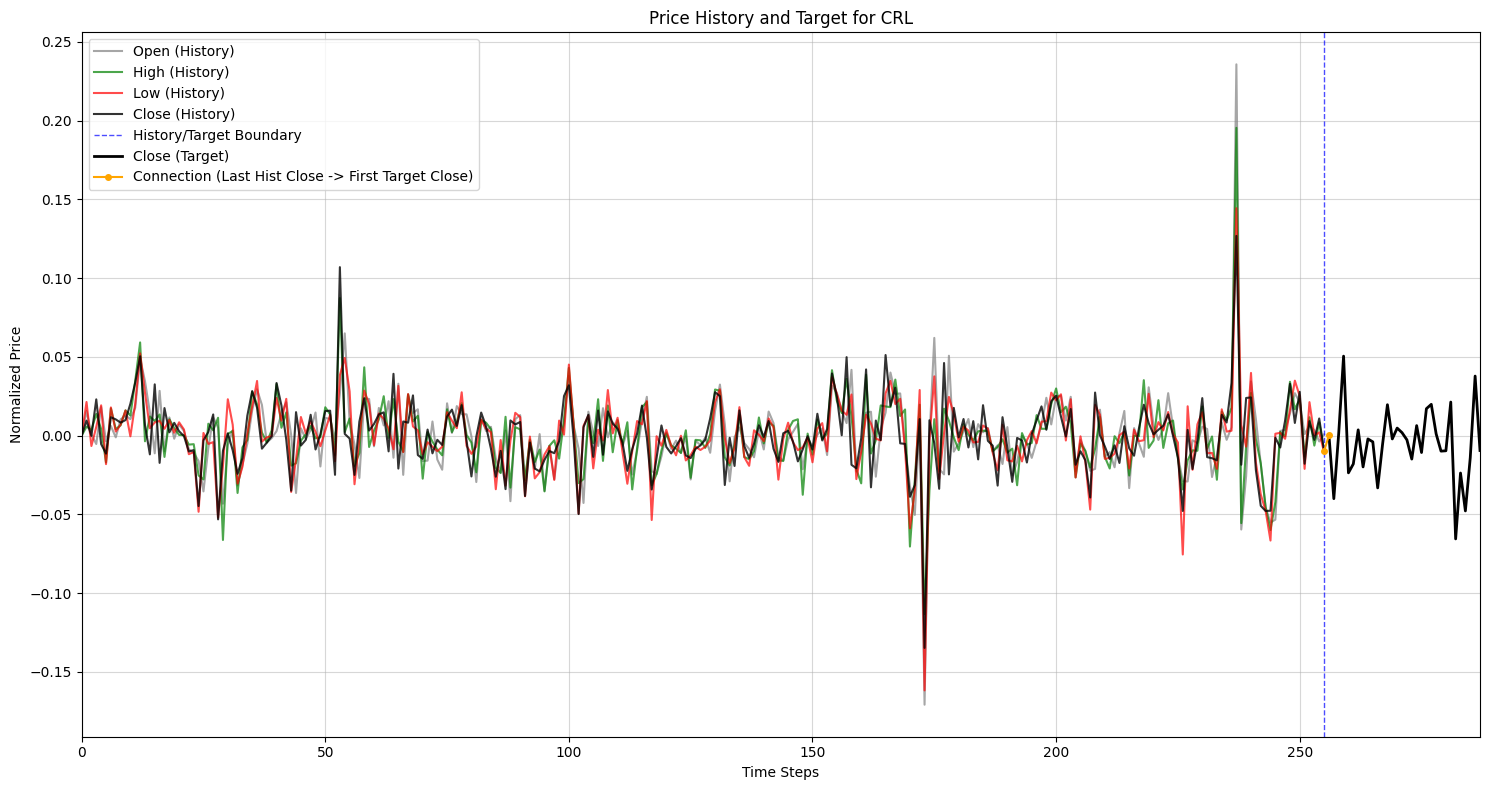

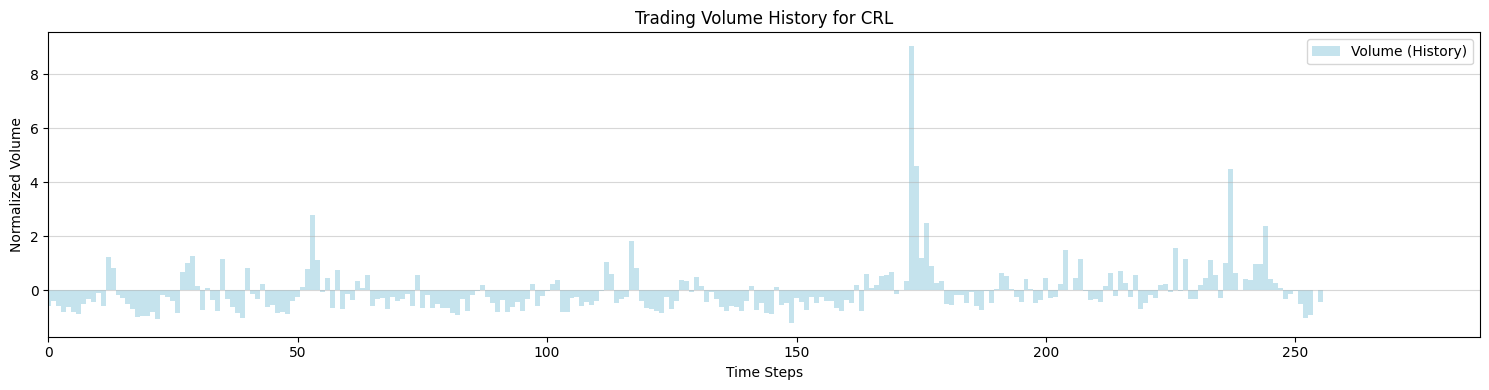

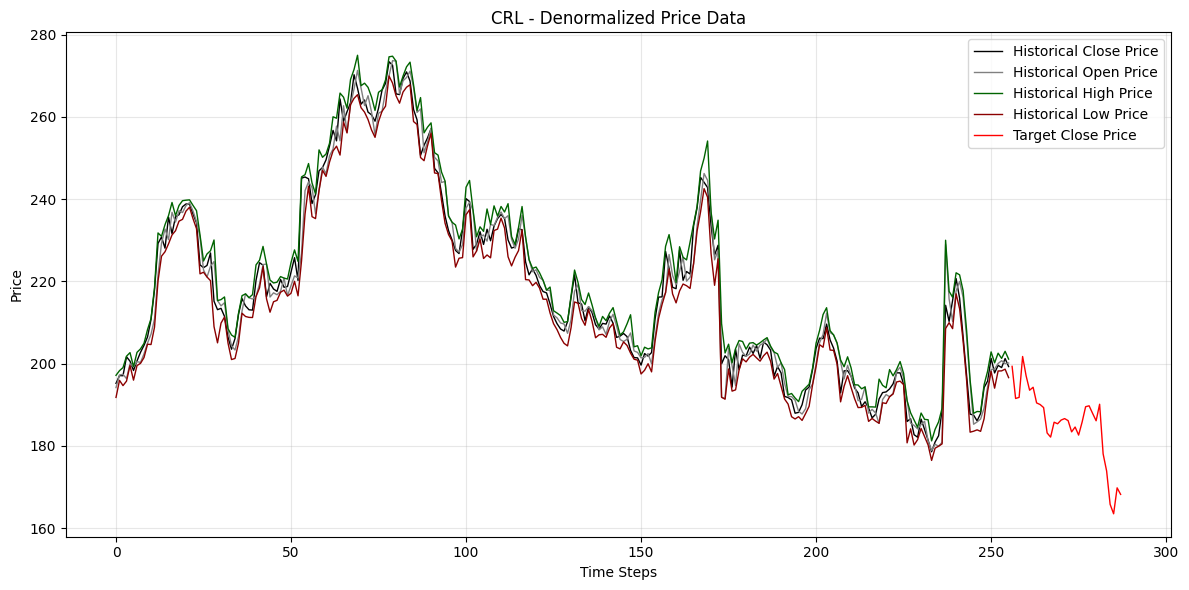

In [47]:
import torch
from utils.visualization import plot_dataset_sample, plot_denormalized_sample


idx = torch.randint(0, len(dataset), (1,)).item()
sample = dataset[idx]
print(f"History shape: {sample['history'].shape}")
print(f"Target shape: {sample['target'].shape}")
print(f"Ticker: {sample['ticker']}")
print(f"Stats: {sample['stats']}")


plot_dataset_sample(sample)
plot_denormalized_sample(sample)

In [3]:
# from utils.dataset import TradingDataset

# dataset = TradingDataset(data_path='data/', mode='train')

In [4]:
# import torch
# from utils.visualization import plot_dataset_sample

# sample = dataset[torch.randint(0, len(dataset), (1,)).item()]

# print("History shape:", sample['history'].shape)   # torch.Size([1, 256, 5])
# print("Target shape:", sample['target'].shape)     # torch.Size([1, 32, 1])
# print("Ticker:", sample['ticker'])

# plot_dataset_sample(sample)